In [2]:
# Cell 0
# All the needed imports

import numpy as np
import pandas as pd
#%pip install nltk
import nltk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from IPython.display import display



In [3]:
#nltk.download('all')

In [4]:
# Cell 1
# Load the raw data

original_df = pd.read_csv('ks-projects-201801.csv')

# Remove all nans
original_df = original_df.dropna()
display(original_df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
# Cell 2
# Reorganize the data

# Drop the following columns: ID, usd_pledged, usd_pledged_real, usd_goal_real
df = original_df.drop(
    ["pledged", "usd pledged", "usd_pledged_real", "goal", "backers"], axis=1
)

# Rename the columns
df = df.rename(
    columns={
        "ID": "id",
        "name": "name",
        "category": "category",
        "main_category": "main_category",
        "deadline": "deadline",
        "launched": "launched",
        "state": "state",
        "currency": "currency",
        "country": "country",
        "usd_goal_real": "goal",
    }
)

# Conver the launch and deadline to year-month-day
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched'], format="%Y-%m-%d %H:%M:%S").dt.date)
df['deadline'] = pd.to_datetime(pd.to_datetime(df['deadline'], format="%Y-%m-%d").dt.date)

# Calculate the amount of days between launch and deadline
df['durration'] = (df['deadline'] - df['launched']).dt.days
df['start_month'] = df['launched'].dt.month_name()
df['end_month'] = df['deadline'].dt.month_name()
df['start_day_name'] = df['launched'].dt.day_name()
df['end_day_name'] = df['deadline'].dt.day_name()
display(df.head())

,id,name,category,main_category,currency,deadline,launched,state,country,goal,durration,start_month,end_month,start_day_name,end_day_name
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,GB,1533.95,59,August,October,Tuesday,Friday
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,US,30000.00,60,September,November,Saturday,Wednesday
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,US,45000.00,45,January,February,Saturday,Tuesday
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,US,5000.00,30,March,April,Saturday,Monday
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04,canceled,US,19500.00,56,July,August,Saturday,Saturday


In [6]:
# Print start shape
print(df.shape)

# Keep only success or fail
df = df[(df['state'] == 'failed') | (df['state'] == 'successful')]

# Remove country
df = df[df['country'] != 'N,0"']

# df = df.drop(columns=['currency', 'country'], axis=1)

# Reset index
df = df.reset_index(drop=True)

# Print end shape
print(df.shape)

# Final data before one hot encoding everything
display(df.head())

(374860, 15)
(331462, 15)


,id,name,category,main_category,currency,deadline,launched,state,country,goal,durration,start_month,end_month,start_day_name,end_day_name
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,GB,1533.95,59,August,October,Tuesday,Friday
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,US,30000.00,60,September,November,Saturday,Wednesday
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,US,45000.00,45,January,February,Saturday,Tuesday
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,US,5000.00,30,March,April,Saturday,Monday
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26,successful,US,50000.00,35,February,April,Friday,Friday


In [7]:
def sentiment_analysis(df: pd.DataFrame, name):
    sia = SentimentIntensityAnalyzer()
    result = [] 
    for _, row in tqdm(df.iterrows(), total=len(df)):
        text = row[name]
        temp = sia.polarity_scores(text)
        result.append([temp['neg'], temp['neu'], temp['pos'], temp['compound']])
    # Generate column names
    column_names = []
    for value in ['negative', 'neutral', 'positive', 'compound']:
        column_names.append(f"{name}_{str(value)}")

    # Create a pandas DataFrame
    data_df = pd.DataFrame(np.array(result), columns=column_names)

    # Return the final new DataFrame
    # print(new_df.shape)
    # print(data_df.dropna().shape)

    df = df.reset_index(drop=True)
    data_df = data_df.reset_index(drop=True)
    return pd.concat([df, data_df], axis=1)
df = sentiment_analysis(df, 'name')

  0%|          | 0/331462 [00:00<?, ?it/s]

In [8]:
display(df.head(n=5))


,id,name,category,main_category,currency,deadline,launched,state,country,goal,durration,start_month,end_month,start_day_name,end_day_name,name_negative,name_neutral,name_positive,name_compound
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,GB,1533.95,59,August,October,Tuesday,Friday,0.0,1.000,0.000,0.0000
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,US,30000.00,60,September,November,Saturday,Wednesday,0.0,0.729,0.271,0.3818
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,US,45000.00,45,January,February,Saturday,Tuesday,0.0,1.000,0.000,0.0000
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,US,5000.00,30,March,April,Saturday,Monday,0.0,0.690,0.310,0.4019
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26,successful,US,50000.00,35,February,April,Friday,Friday,0.0,1.000,0.000,0.0000


In [9]:
def one_hot_encode_column(df: pd.DataFrame, name):
    # The existing column
    column = df[name]

    # Dataframe without the existing column
    new_df = df.drop([name], axis=1)

    # Get the unique values
    unique = column.unique()
    print(unique)

    # Create a mapping from the unique value to the index
    mapping = {key: index for index, key in enumerate(unique)}

    # The encoded data
    encoded = np.zeros((df.shape[0], len(unique)))

    # Show mapping
    # for key, index in mapping.items():
    #     temp = np.zeros((len(unique)))
    #     temp[index] = 1.0
    #     print(f"{temp}: {key}")

    # Encode each value
    for offset, value in enumerate(column):
        index = mapping[value]
        encoded[offset][index] = 1

    # Generate column names
    column_names = []
    for value in unique:
        column_names.append(f"{name}_{str(value)}")

    # Create a pandas DataFrame
    data_df = pd.DataFrame(encoded, columns=column_names, dtype=np.uint8)

    # Return the final new DataFrame
    # print(new_df.shape)
    # print(data_df.dropna().shape)

    new_df = new_df.reset_index(drop=True)
    data_df = data_df.reset_index(drop=True)
    return pd.concat([new_df, data_df], axis=1)

df = one_hot_encode_column(df, "category")
df = one_hot_encode_column(df, "main_category")
df = one_hot_encode_column(df, "currency")
df = one_hot_encode_column(df, "country")
df = one_hot_encode_column(df, "start_month")
df = one_hot_encode_column(df, "end_month")
df = one_hot_encode_column(df, "start_day_name")
df = one_hot_encode_column(df, "end_day_name")


['Poetry' 'Narrative Film' 'Music' 'Restaurants' 'Food' 'Drinks'
 'Nonfiction' 'Indie Rock' 'Crafts' 'Games' 'Tabletop Games' 'Design'
 'Comic Books' 'Art Books' 'Fashion' 'Childrenswear' 'Theater' 'Comics'
 'DIY' 'Webseries' 'Animation' 'Food Trucks' 'Product Design' 'Public Art'
 'Documentary' 'Illustration' 'Photography' 'Pop' 'People' 'Art' 'Family'
 'Fiction' 'Film & Video' 'Accessories' 'Rock' 'Hardware' 'Software'
 'Weaving' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals' 'Video Games'
 'Anthologies' 'Publishing' 'Shorts' 'Gadgets' 'Electronic Music'
 'Radio & Podcasts' 'Cookbooks' 'Apparel' 'Metal' 'Comedy' 'Hip-Hop'
 'Periodicals' 'Dance' 'Technology' 'Painting' 'World Music' 'Photobooks'
 'Drama' 'Architecture' 'Young Adult' 'Latin' 'Mobile Games' 'Flight'
 'Fine Art' 'Action' 'Playing Cards' 'Makerspaces' 'Punk'
 "Children's Books" 'Apps' 'Audio' 'Performance Art' 'Ceramics' 'Vegan'
 'Graphic Novels' 'Fabrication Tools' 'Performances' 'Sculpture' 'Sound'
 'Stationery' 'Print' "Farm

In [10]:
df_features = df.copy()
df_features = df_features.drop(columns=['name', 'state', 'deadline', 'launched'], axis=1)
# Normalize goal and duration
df_features['goal'] = (df_features['goal'] - df_features['goal'].mean()) / df_features['goal'].std()
df_features['durration'] = (df_features['durration'] - df_features['durration'].mean()) / df_features['durration'].std()
# df_features['start_year'] = (df_features['start_year'] - df_features['start_year'].mean()) / df_features['start_year'].std()
# df_features['end_year'] = (df_features['end_year'] - df_features['end_year'].mean()) / df_features['end_year'].std()
df_labels = df[['id', 'state']]
df_labels['state'] = (df['state'] == 'successful').astype(np.uint8)

C:\Users\Colli\AppData\Local\Temp\ipykernel_18284\1336704207.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['state'] = (df['state'] == 'successful').astype(np.uint8)


In [11]:
# Get the min and max years
display(df_features.head())
print(df['launched'].dt.year.min())
print(df['launched'].dt.year.max())

,id,goal,durration,name_negative,name_neutral,name_positive,name_compound,category_Poetry,category_Narrative Film,category_Music,...,start_day_name_Wednesday,start_day_name_Thursday,start_day_name_Sunday,end_day_name_Friday,end_day_name_Wednesday,end_day_name_Tuesday,end_day_name_Monday,end_day_name_Sunday,end_day_name_Thursday,end_day_name_Saturday
0,1000002330,-0.036049,1.969794,0.0,1.000,0.000,0.0000,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1000003930,-0.010388,2.048447,0.0,0.729,0.271,0.3818,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1000004038,0.003135,0.868651,0.0,1.000,0.000,0.0000,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1000007540,-0.032925,-0.311144,0.0,0.690,0.310,0.4019,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1000014025,0.007642,0.082121,0.0,1.000,0.000,0.0000,0,0,0,...,0,0,0,1,0,0,0,0,0,0


2009
2017


In [12]:
def success_failure_summary(labels):
    success_count = labels['state'].sum()
    fail_count = labels.shape[0] - success_count 
    print(f"# success: {success_count}")
    print(f"# fail: {fail_count}")
    print(f"Percent containin success: {round(success_count / labels.shape[0] * 100, 2)}")
    print(f"Percent containin fail: {round(fail_count / labels.shape[0] * 100, 2)}")

success_failure_summary(df_labels)
success_mask = df_labels['state'] == 1
success_features = df_features[success_mask]
success_labels = df_labels[success_mask]
fail_mask = df_labels['state'] != 1
fail_features = df_features[fail_mask]
fail_labels = df_labels[fail_mask]
min_length = min(success_mask.sum(), fail_mask.sum())
success_features = success_features.head(min_length)
success_labels = success_labels.head(min_length)
fail_features = fail_features.head(min_length)
fail_labels = fail_labels.head(min_length)
final_labels = pd.concat([success_labels, fail_labels], axis=0)
final_features =pd.concat([success_features, fail_features], axis=0)
print(df_features.shape)
print(final_features.shape)
display(final_features.head())
success_failure_summary(final_labels)

# X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.20)
X_train, X_test, y_train, y_test = train_test_split(final_features, final_labels, test_size=0.20)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
display(X_train.head())
display(y_train.head())

# success: 133851
# fail: 197611
Percent containin success: 40.38
Percent containin fail: 59.62
(331462, 255)
(267702, 255)


,id,goal,durration,name_negative,name_neutral,name_positive,name_compound,category_Poetry,category_Narrative Film,category_Music,...,start_day_name_Wednesday,start_day_name_Thursday,start_day_name_Sunday,end_day_name_Friday,end_day_name_Wednesday,end_day_name_Tuesday,end_day_name_Monday,end_day_name_Sunday,end_day_name_Thursday,end_day_name_Saturday
4,1000014025,0.007642,0.082121,0.000,1.000,0.000,0.0000,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1000023410,-0.036531,-1.097675,0.000,0.495,0.505,0.6239,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,100005484,-0.026164,-0.311144,0.000,1.000,0.000,0.0000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11,1000057089,-0.031600,-0.468450,0.000,1.000,0.000,0.0000,0,0,0,...,1,0,0,0,1,0,0,0,0,0
15,1000070642,-0.037207,-1.490940,0.333,0.667,0.000,-0.2500,0,0,1,...,0,1,0,1,0,0,0,0,0,0


# success: 133851
# fail: 133851
Percent containin success: 50.0
Percent containin fail: 50.0


,id,goal,durration,name_negative,name_neutral,name_positive,name_compound,category_Poetry,category_Narrative Film,category_Music,...,start_day_name_Wednesday,start_day_name_Thursday,start_day_name_Sunday,end_day_name_Friday,end_day_name_Wednesday,end_day_name_Tuesday,end_day_name_Monday,end_day_name_Sunday,end_day_name_Thursday,end_day_name_Saturday
0,1655719369,-0.032564,-0.232491,0.0,1.000,0.000,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2008435790,-0.035629,0.082121,0.0,1.000,0.000,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,19561117,-0.023910,-0.311144,0.0,0.667,0.333,0.4574,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,995826533,-0.032553,-0.311144,0.0,1.000,0.000,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,978957400,-0.037423,-0.311144,0.0,1.000,0.000,0.0000,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,state
0,1655719369,1
1,2008435790,0
2,19561117,0
3,995826533,1
4,978957400,1


In [13]:
# Lastly Drop all ids
final_X_train =  X_train.drop(columns=['id'], axis=1)
final_X_test = X_test.drop(columns=['id'], axis=1)
final_y_train = y_train.drop(columns=['id'], axis=1)
final_y_test = y_test.drop(columns=['id'], axis=1)

# PCA
# X = final_X_train - np.mean(final_X_train, axis=0)
# U, _, _ = np.linalg.svd(X.T, full_matrices=False)
# G = U[:, :50]
# final_X_train = np.dot(G.T, X.T).T
# final_X_test = np.dot(G.T, (final_X_test - np.mean(final_X_test, axis=0)).T).T


In [14]:

# PCA code
knn = KNeighborsClassifier(n_neighbors=518, weights='distance', metric='l1')
knn.fit(final_X_train, final_y_train.values.ravel())
print(f"{knn.predict(final_X_test[0:10])} vs {final_y_test['state'].values[0:10]}")

# Non-PCA code
# knn.fit(final_X_train.values, final_y_train.values.ravel())
# print(f"{knn.predict(final_X_test[0:10])} vs {final_y_test['state'].values[0:10]}")


[0 1 1 0 1 1 1 1 0 1] vs [0 1 1 1 1 1 0 1 0 1]


In [15]:
predict_y_test = knn.predict(final_X_test)

(331462, 259)
(214161, 1)
(53541, 1)
 --- Training Data ---
# success: 107101
# fail: 107060
Percent containin success: 50.01
Percent containin fail: 49.99

 --- Testing Data ---
# success: 26750
# fail: 26791
Percent containin success: 49.96
Percent containin fail: 50.04

 --- KNN Report ---
              precision    recall  f1-score   support

           0       0.63      0.60      0.61     26791
           1       0.62      0.64      0.63     26750

    accuracy                           0.62     53541
   macro avg       0.62      0.62      0.62     53541
weighted avg       0.62      0.62      0.62     53541



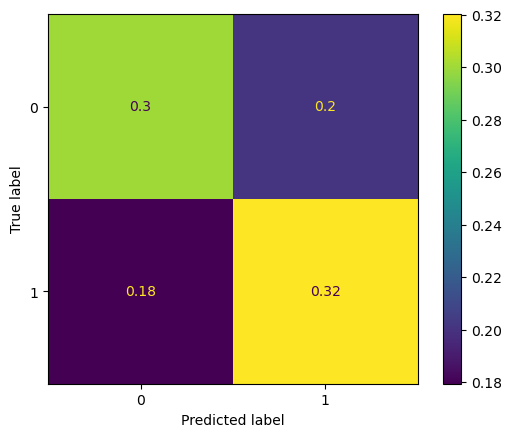

In [16]:
print(df.shape)
print(final_y_train.shape)
print(final_y_test.shape)

print(" --- Training Data ---")
success_failure_summary(y_train)
print()

print(" --- Testing Data ---")
success_failure_summary(y_test)
print()

print(" --- KNN Report ---")
print(classification_report(final_y_test.values.ravel(), predict_y_test))

m = confusion_matrix(final_y_test.values.ravel(), predict_y_test)
m = m / m.sum()
ConfusionMatrixDisplay(m).plot()
plt.show()
None